In [501]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import time, calendar
import graphlab as gl
%matplotlib inline

A newer version of GraphLab Create (v1.8.5) is available! Your current version is v1.8.4.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.


# Connect to MongoDB

In [307]:
conn = pymongo.MongoClient()['steam']
cursor = conn['test'].find({})

In [308]:
df = pd.DataFrame(list(cursor))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 7 columns):
_id                656 non-null object
ban_status         656 non-null object
friends            656 non-null object
game_info          656 non-null object
profile_summary    656 non-null object
steamid            656 non-null object
user_info          656 non-null object
dtypes: object(7)
memory usage: 35.9+ KB


In [39]:
#games = df.copy()
#games = games[["steamid", "game_info"]]

# Unpack Columns Containing a Single Dictionary

In [12]:
def unpack(df, column, fillna=None):
    new_df = None
    if fillna is None:
        new_df = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems()))], axis=1)
        del new_df[column]
    else:
        new_df = pd.concat([df, pd.DataFrame((d for idx, d in df[column].iteritems())).fillna(fillna)], axis=1)
        del new_df[column]
    return new_df

#unpack(tf, 'nested', 0)

In [309]:
df = unpack(df, "user_info", fillna=None)

In [310]:
df = unpack(df, "ban_status", fillna=None)

In [259]:
df.head(1)

,_id,friends,game_info,profile_summary,steamid,avatarfull,commentpermission,communityvisibilitystate,gameextrainfo,gameid,...,primaryclanid,profilestate,realname,timecreated,CommunityBanned,DaysSinceLastBan,EconomyBan,NumberOfGameBans,NumberOfVACBans,VACBanned
0,570fc54763210f0e63d825fc,"[{u'steamid': u'76561197962935145', u'friend_s...","[{u'playtime_forever': 63, u'playtime_2weeks':...",No information given.,76561197981918203,https://steamcdn-a.akamaihd.net/steamcommunity...,NaN,3,NaN,NaN,...,103582791429521408,1.0,NaN,1.144367e+09,False,0,none,0,0,False


# Split up users based on public or private profiles

In [311]:
df2 = df.copy()
private_df = df2[df2["profile_summary"] == "private"]
public_df = df2[df2["profile_summary"] != "private"]

In [312]:
private_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 3 to 654
Data columns (total 28 columns):
_id                         110 non-null object
friends                     110 non-null object
game_info                   110 non-null object
profile_summary             110 non-null object
steamid                     110 non-null object
avatarfull                  110 non-null object
commentpermission           21 non-null float64
communityvisibilitystate    110 non-null int64
gameextrainfo               0 non-null object
gameid                      0 non-null object
gameserverip                0 non-null object
gameserversteamid           0 non-null object
lastlogoff                  110 non-null int64
loccityid                   0 non-null float64
loccountrycode              0 non-null object
locstatecode                0 non-null object
personaname                 110 non-null object
personastate                110 non-null int64
primaryclanid               0 non-null object
p

In [58]:
private_df["VACBanned"].value_counts()#`.replace(["none"], 0).value_counts()

False    107
True       3
Name: VACBanned, dtype: int64

# Who needs these columns?

In [313]:
del public_df["_id"]
del public_df["gameid"]
del public_df["commentpermission"]
del public_df["gameserverip"]
del public_df["gameserversteamid"]
del public_df["gameextrainfo"]

In [741]:
public_df.head()

,friends,game_info,profile_summary,steamid,avatarfull,communityvisibilitystate,lastlogoff,loccityid,loccountrycode,locstatecode,...,primaryclanid,profilestate,realname,timecreated,CommunityBanned,DaysSinceLastBan,EconomyBan,NumberOfGameBans,NumberOfVACBans,VACBanned
0,"[{u'steamid': u'76561197962935145', u'friend_s...","[{u'steamid': u'76561197981918203', u'playtime...",No information given.,76561197981918203,https://steamcdn-a.akamaihd.net/steamcommunity...,3,1460650784,NaN,NaN,NaN,...,103582791429521408,1.0,NaN,1.144367e+09,False,0,none,0,0,False
1,"[{u'steamid': u'76561197960384644', u'friend_s...","[{u'steamid': u'76561197993408842', u'playtime...",No information given.,76561197993408842,https://steamcdn-a.akamaihd.net/steamcommunity...,3,1460141117,NaN,NaN,NaN,...,103582791434327939,1.0,Kyle Wayman,1.192434e+09,False,0,none,0,0,False
2,"[{u'steamid': u'76561197965354025', u'friend_s...","[{u'steamid': u'76561198042305043', u'playtime...",Trying out more options on the PC. Hope to fin...,76561198042305043,https://steamcdn-a.akamaihd.net/steamcommunity...,3,1460619106,1581.0,US,KY,...,103582791429521408,1.0,Russ,1.306214e+09,False,0,none,0,0,False
4,"[{u'steamid': u'76561197961563067', u'friend_s...","[{u'steamid': u'76561197980092471', u'playtime...",I come from a time and place you wouldn't unde...,76561197980092471,https://steamcdn-a.akamaihd.net/steamcommunity...,3,1459313201,669.0,US,CO,...,103582791434535150,1.0,Alan,1.136080e+09,False,0,none,0,0,False
5,"[{u'steamid': u'76561197966730410', u'friend_s...","[{u'steamid': u'76561198202663196', u'playtime...",No information given.,76561198202663196,https://steamcdn-a.akamaihd.net/steamcommunity...,3,1460633747,NaN,NaN,NaN,...,103582791429521408,1.0,NaN,1.419689e+09,False,0,none,0,0,False


# Some Friend Exploration

In [742]:
friends = public_df.copy()
friends = friends[["steamid", "friends"]]

In [743]:
friends.head()

,steamid,friends
0,76561197981918203,"[{u'steamid': u'76561197962935145', u'friend_s..."
1,76561197993408842,"[{u'steamid': u'76561197960384644', u'friend_s..."
2,76561198042305043,"[{u'steamid': u'76561197965354025', u'friend_s..."
4,76561197980092471,"[{u'steamid': u'76561197961563067', u'friend_s..."
5,76561198202663196,"[{u'steamid': u'76561197966730410', u'friend_s..."


In [745]:
for friend in friends["friends"][0]:
    print friend

{u'steamid': u'76561197962935145', u'friend_since': 1432449524}
{u'steamid': u'76561197976676146', u'friend_since': 0}
{u'steamid': u'76561198015033918', u'friend_since': 1357182390}
{u'steamid': u'76561198028166561', u'friend_since': 1432450611}
{u'steamid': u'76561198041265016', u'friend_since': 1436389663}
{u'steamid': u'76561198071700397', u'friend_since': 1357546821}
{u'steamid': u'76561198100020251', u'friend_since': 1435389806}
{u'steamid': u'76561198117260979', u'friend_since': 1435391977}
{u'steamid': u'76561198202327956', u'friend_since': 1419568101}


In [756]:
def friends_users_list(df, pivot=False):
    """
    Assumes a df with public non-null values in the form:
    |   |steamid          |friends          |
    +---+-----------------+-----------------+
    |0  |76561197967398882|[{u'frien...},{}]|
    
    Returns a pivoted data fram where each row is
    'steamid', the columns are game names, and the 
    values are 'playtime_forever' (default) or 
    'playtime_2weeks'
    """
    df = df.set_index("steamid")
    for i in xrange(len(df)):
        
        #[game.update({"steamid":df.iloc[i].name})\
        #           for game in df.iloc[i]["game_info"]\
        #           if str(game["appid"]) in game_id_set]
        
        for friend in df.iloc[i]["friends"]:
            #if str(friend["appid"]) in game_id_set:
            #    game.update({"steamid":df.iloc[i].name})
            #else:
                #df.iloc[i]["game_info"].remove(game)
            friend.update({"uid":df.iloc[i].name})
    
    full_friend_df = pd.DataFrame()
    for user in df["friends"]:
        frienddf = pd.DataFrame(user)
        full_friend_df = full_friend_df.append(frienddf)
    
    #if pivot:
    #    full_gamedf = pd.pivot_table(full_gamedf, index="steamid", columns=["appid"], values="playtime_forever", fill_value=0)
    return full_friend_df

In [757]:
large_friends = friends_users_list(friends)

In [775]:
len(large_friends[large_friends["friend_since"] == 0]["steamid"].unique())

237

In [767]:
friendship_length = (calendar.timegm(time.gmtime()) - longest_frienship)/(3600*24*360.)

In [768]:
friendship_length

7.7078130787037038

In [755]:
[friend for friend in friends.iloc[0]["friends"]]

[{u'friend_since': 1432449524, u'steamid': u'76561197981918203'},
 {u'friend_since': 0, u'steamid': u'76561197981918203'},
 {u'friend_since': 1357182390, u'steamid': u'76561197981918203'},
 {u'friend_since': 1432450611, u'steamid': u'76561197981918203'},
 {u'friend_since': 1436389663, u'steamid': u'76561197981918203'},
 {u'friend_since': 1357546821, u'steamid': u'76561197981918203'},
 {u'friend_since': 1435389806, u'steamid': u'76561197981918203'},
 {u'friend_since': 1435391977, u'steamid': u'76561197981918203'},
 {u'friend_since': 1419568101, u'steamid': u'76561197981918203'}]

In [208]:
def popular_game_set(df):
    """
    Pull out only game appids from 'game_info' whose global 
    forever_playtime is above the average glabal playtime, 
    reducing the number of apps about 90%
    
    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame with column 'game_info', containing
        a list of dictionaries
         
    Returns
    -------
    popular_games : set
        Set of game appids whose global playtime is 
        above the average global playtime
    """
    # Collect the appid and global playtime for each game
    # That all users have played
    
    summed = Counter({})
    for user in df["game_info"]:
        gametime = Counter({})
        for game in user:
            gametime[str(game["appid"])] = game["playtime_forever"]
            if game["appid"] not in summed.keys():
                summed.update(gametime)
        summed += gametime
        
    global_averages = int(np.mean(summed.values()))
    
    # Condense into a set of popular appids
    
    popular_games = set()
    for k, v in summed.iteritems():
        if v >= global_averages:
            popular_games.add(k)
    
    return popular_games

In [220]:
popular_games = popular_game_set(public_df)

In [328]:
games = public_df.copy()
games = games[["steamid", "game_info"]]
#games = games.set_index("steamid")
games.head()

,steamid,game_info
0,76561197981918203,"[{u'steamid': u'76561197981918203', u'playtime..."
1,76561197993408842,"[{u'steamid': u'76561197993408842', u'playtime..."
2,76561198042305043,"[{u'playtime_forever': 84, u'playtime_2weeks':..."
4,76561197980092471,"[{u'playtime_forever': 246, u'playtime_2weeks'..."
5,76561198202663196,"[{u'playtime_forever': 1, u'playtime_2weeks': ..."


# Pivot Table

In [628]:
def games_users_list(df, game_id_set, pivot=False):
    """
    Assumes a df with public non-null values in the form:
    |   |steamid          |game_info        |
    +---+-----------------+-----------------+
    |0  |76561197967398882|[{u'playt...},{}]|
    
    Returns a pivoted data fram where each row is
    'steamid', the columns are game names, and the 
    values are 'playtime_forever' (default) or 
    'playtime_2weeks'
    """
    df = df.set_index("steamid")
    for i in xrange(len(df)):
        
        #[game.update({"steamid":df.iloc[i].name})\
        #           for game in df.iloc[i]["game_info"]\
        #           if str(game["appid"]) in game_id_set]
        
        for game in df.iloc[i]["game_info"]:
            if str(game["appid"]) in game_id_set:
                game.update({"steamid":df.iloc[i].name})
            else:
                df.iloc[i]["game_info"].remove(game)
    
    full_gamedf = pd.DataFrame()
    for user in df["game_info"]:
        gamedf = pd.DataFrame(user)
        full_gamedf = full_gamedf.append(gamedf)
    
    if pivot:
        full_gamedf = pd.pivot_table(full_gamedf, index="steamid", columns=["appid"], values="playtime_forever", fill_value=0)
    return full_gamedf

In [352]:
games_matrix = sparse_games(games, popular_games)
games_matrix.head()

playtime_forever                                            \
appid                       10     70     220    240    280    300    380      
steamid                                                                        
76561197960273048             2337      0      0   1076      0      0      0   
76561197960277603              230      0      0    809      0    151      0   
76561197960281410                0      0      0      0      0     82    259   
76561197960282871               46      0      0   1815      0     62      0   
76561197960303286              126      0     22     60      0      0      0   

                                         ...                                \
appid             400    420     440     ...   300550 301520 304030 304930   
steamid                                  ...                                 
76561197960273048     38    265    3873  ...        0      0      0    211   
76561197960277603      7      0  326971  ...        0      0      0      0   
76561197960281410      5    395       0  ...        0   5183      0     42   
76561197960282871     66    385     166  ...       54      0      0      0   
76561197960303286    119      0    4452  ...        0      0      0      0   

                                                             
appid             322330 346110 346900 359320 363970 377160  
steamid                                                      
76561197960273048      0      0      0      0      0      0  
76561197960277603      0      0      0      0      0      0  
76561197960281410      0      0      0      0      0      0  
76561197960282871      0    372      0     27     29      0  
76561197960303286      0      0     83    198      0      0  

[5 rows x 378 columns]

# Bin columns based on playtime
* ### Add a weight for profile age?


|playtime [min]|     rating     |
|--------------|----------------|
|    0         |      0         |
|    1-60      |      1         |
|    61-120    |      2         |
|    121-600   |      3         |
|    601-1200  |      4         |
|    1201 +    |      5         |
`pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)`

In [475]:
profile_length = (calendar.timegm(time.gmtime()) - public_df["timecreated"])/(3600*24*365) # In years

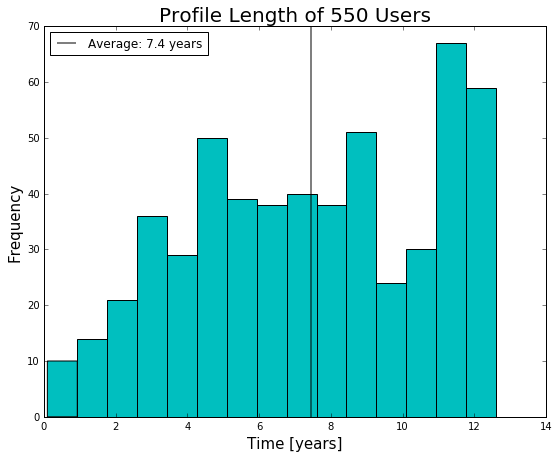

In [500]:
plt.figure(figsize=(9,7))
plt.hist(profile_length, bins=15, color='c')
plt.ylabel("Frequency", fontsize=15)
plt.vlines(profile_length.mean(), 0, 70, lw=2, alpha=0.5,\
           label="Average: {} years".format(round(profile_length.mean(),1)))
plt.xlabel("Time [years]", fontsize=15)
plt.title("Profile Length of 550 Users", fontsize=20)
plt.legend(loc="upper left", prop={"size":12})
plt.show()

In [455]:
dota2 = games_matrix.playtime_forever[570]
csgo = games_matrix.playtime_forever[730]
skyrim = games_matrix.playtime_forever[72850]
tf2 = games_matrix.playtime_forever[440]

In [456]:
dota2_vals = pd.cut(dota2, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()
csgo_vals = pd.cut(csgo, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()
skyrim_vals = pd.cut(skyrim, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()
tf2_vals = pd.cut(tf2, bins=[-1, 0, 60, 120, 600, 1200, 10e10], labels=[0,1,2,3,4,5]).value_counts()#, labels=[0,1,2,3,4,5]

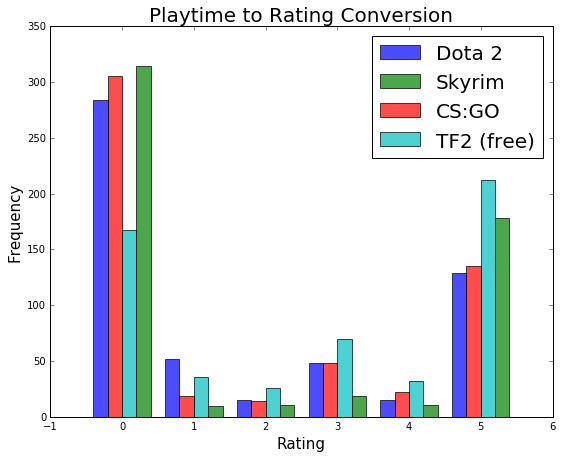

In [502]:
plt.figure(figsize=(9,7))
ax = plt.subplot(111)
ax.bar(np.array(dota2_vals.index)-0.3, dota2_vals.values, width=0.2, align="center", alpha=0.7, color='b', label="Dota 2")
ax.bar(np.array(skyrim_vals.index)+0.3, skyrim_vals.values, width=0.2, align="center", alpha=0.7, color='g', label="Skyrim")
ax.bar(np.array(csgo_vals.index)-0.1, csgo_vals.values, width=0.2, align="center", alpha=0.7, color='r', label="CS:GO")
ax.bar(np.array(tf2_vals.index)+0.1, tf2_vals.values, width=0.2, align="center", alpha=0.7, color='c', label="TF2 (free)")
ax.legend(loc="upper right", prop={'size':20})
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Rating", fontsize=15)
plt.title("Playtime to Rating Conversion", fontsize=20)
plt.show()

In [522]:
adjusted_games = games_matrix.copy()

In [578]:
game_ratings = pd.DataFrame()
for col in adjusted_games["playtime_forever"]:
    adjusted_column = pd.cut(adjusted_games["playtime_forever"][col],\
                                              bins=[-1, 0, 60, 120, 600, 1200, 10e10],\
                                              labels=[0,1,2,3,4,5])
    game_ratings[col] = adjusted_column

In [585]:
game_ratings.head()

,10,70,220,240,280,300,380,400,420,440,...,300550,301520,304030,304930,322330,346110,346900,359320,363970,377160
steamid,,,,,,,,,,,,,,,,,,,,,
76561197960273048,5,0,0,4,0,0,0,1,3,5,...,0,0,0,3,0,0,0,0,0,0
76561197960277603,3,0,0,4,0,3,0,1,0,5,...,0,0,0,0,0,0,0,0,0,0
76561197960281410,0,0,0,0,0,2,3,1,3,0,...,0,5,0,1,0,0,0,0,0,0
76561197960282871,1,0,0,5,0,2,0,2,3,3,...,1,0,0,0,0,3,0,1,1,0
76561197960303286,3,0,1,1,0,0,0,2,0,5,...,0,0,0,0,0,0,2,3,0,0


# Attempted Modeling?
```python
item_similarity_recommender
factorization_recommender
item_similarity_recommender
ranking_factorization_recommender

data = graphlab.SFrame({'user_id': ["Ann", "Ann", "Ann", "Brian", "Brian", "Brian"],
                          'item_id': ["Item1", "Item2", "Item4", "Item2", "Item3", "Item5"],
                          'rating': [1, 3, 2, 5, 4, 2]})
m = graphlab.factorization_recommender.create(data, target='rating')

recommendations = m.recommend()
```
### [GraphLab - Choosing a model](https://dato.com/learn/userguide/recommender/choosing-a-model.html)

In [695]:
games_users_ratings.tail()

,appid,name,playtime_2weeks,playtime_forever,steamid,ratings_forever,ratings_2weeks
10,295110,H1Z1: Just Survive,0,973,76561198129253664,4,0
11,304930,Unturned,0,586,76561198129253664,3,0
12,730,Counter-Strike: Global Offensive,0,12696,76561198129253664,5,0
13,346110,ARK: Survival Evolved,0,502,76561198129253664,3,0
14,570,Dota 2,0,11,76561198129253664,1,0


In [696]:
gl_data = gl.SFrame({'user_id': games_users_ratings["steamid"],
                          'item_id': games_users_ratings["appid"],
                          'rating': games_users_ratings["ratings_forever"]})

In [697]:
model = gl.factorization_recommender.create(gl_data, target='rating')

Recsys training: model = factorization_recommender

Preparing data set.

Data has 29288 observations with 543 users and 378 items.

Data prepared in: 0.131871s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 29288 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 1.91625                                  |

| 5       | 0.0488281         | 2.27235                                  |

| 6       | 0.0244141         | 2.29189                                  |

| 7       | 0.012207          | 2.35426                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 1.91625                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 113us        | 3.76108           | 1.93935               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 104.561ms    | 3.9505            | 1.98758               | 0.0976562   |

| 2       | 179.466ms    | 3.36024           | 1.83309               | 0.0580668   |

| 3       | 249.363ms    | 2.69741           | 1.64237               | 0.042841    |

| 4       | 388.629ms    | 2.30476           | 1.51814               | 0.0290334   |

| 5       | 528.228ms    | 2.1072            | 1.45161               | 0.0245592   |

| 6       | 582.419ms    | 1.99783           | 1.41344               | 0.0214205   |

| 10      | 1.08s        | 1.78404           | 1.33567               | 0.014603    |

| 11      | 1.16s        | 1.75395           | 1.32436               | 0.0135956   |

| 20      | 1.53s        | 1.61171           | 1.26952               | 0.008683    |

| 30      | 2.28s        | 1.54567           | 1.24324               | 0.00640622  |

| 40      | 2.82s        | 1.50881           | 1.22832               | 0.00516295  |

| 50      | 3.31s        | 1.48493           | 1.21856               | 0.00436732  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.39469

Final training RMSE: 1.18095

In [737]:
similar_users = model.get_similar_users(["76561198046747311"], k=5)
similar_users

Getting similar users completed in 0.000749

user_id,similar,score,rank
76561198046747311,76561198046215093,0.855458080769,1
76561198046747311,76561197981918203,0.837264835835,2
76561198046747311,76561198023511329,0.802134335041,3
76561198046747311,76561198089389797,0.800871193409,4
76561198046747311,76561198068456702,0.775933504105,5


In [740]:
games_users_ratings[games_users_ratings["steamid"]=="76561198089389797"].sort_values(by="playtime_forever", ascending=False).head(10)

,appid,name,playtime_2weeks,playtime_forever,steamid,ratings_forever,ratings_2weeks
4,236390,War Thunder,0,11249,76561198089389797,5,0
2,113400,APB Reloaded,0,2628,76561198089389797,5,0
12,440,Team Fortress 2,0,1868,76561198089389797,5,0
0,4000,Garry's Mod,125,1696,76561198089389797,5,3
10,730,Counter-Strike: Global Offensive,92,1597,76561198089389797,5,2
8,200110,Nosgoth,0,947,76561198089389797,4,0
6,304930,Unturned,0,909,76561198089389797,4,0
1,20900,The Witcher: Enhanced Edition,0,815,76561198089389797,4,0
7,224600,Defiance,0,776,76561198089389797,4,0
3,230410,Warframe,0,599,76561198089389797,3,0


In [739]:
games_users_ratings[games_users_ratings["steamid"]=="76561198046747311"].sort_values(by="playtime_forever", ascending=False).head(10)

,appid,name,playtime_2weeks,playtime_forever,steamid,ratings_forever,ratings_2weeks
36,730,Counter-Strike: Global Offensive,2181,28268,76561198046747311,5,5
59,218620,PAYDAY 2,143,26100,76561198046747311,5,3
0,4000,Garry's Mod,2,18123,76561198046747311,5,1
81,440,Team Fortress 2,0,14241,76561198046747311,5,0
15,10,Counter-Strike,0,11862,76561198046747311,5,0
55,233450,Prison Architect,0,4146,76561198046747311,5,0
25,550,Left 4 Dead 2,0,4113,76561198046747311,5,0
62,252490,Rust,0,3343,76561198046747311,5,0
67,244850,Space Engineers,3,3333,76561198046747311,5,1
18,240,Counter-Strike: Source,0,3138,76561198046747311,5,0


In [690]:
games_users_ratings = games_users_list(games, popular_games)

In [693]:
games_users_ratings["ratings_forever"] = pd.cut(games_users_ratings["playtime_forever"],\
                                          bins=[-1, 0, 60, 120, 600, 1200, 10e10], \
                                          labels=[0,1,2,3,4,5])
games_users_ratings["ratings_2weeks"] = pd.cut(games_users_ratings["playtime_2weeks"],\
                                          bins=[-1, 0, 60, 120, 600, 1200, 10e10], \
                                          labels=[0,1,2,3,4,5])
games_users_ratings.tail()

,appid,name,playtime_2weeks,playtime_forever,steamid,ratings_forever,ratings_2weeks
10,295110,H1Z1: Just Survive,0,973,76561198129253664,4,0
11,304930,Unturned,0,586,76561198129253664,3,0
12,730,Counter-Strike: Global Offensive,0,12696,76561198129253664,5,0
13,346110,ARK: Survival Evolved,0,502,76561198129253664,3,0
14,570,Dota 2,0,11,76561198129253664,1,0


In [718]:
games_users_ratings[games_users_ratings["name"]=="Half-Life 2"].sort_values(by="playtime_forever")

,appid,name,playtime_2weeks,playtime_forever,steamid,ratings_forever,ratings_2weeks
0,220,Half-Life 2,0,0,76561197974981757,0,0
1,220,Half-Life 2,0,0,76561197970109671,0,0
7,220,Half-Life 2,0,0,76561197962265797,0,0
2,220,Half-Life 2,0,0,76561197960798610,0,0
0,220,Half-Life 2,0,0,76561197973549873,0,0
2,220,Half-Life 2,0,0,76561197960416122,0,0
1,220,Half-Life 2,0,0,76561198080506584,0,0
2,220,Half-Life 2,0,0,76561197999167393,0,0
2,220,Half-Life 2,0,0,76561197969381714,0,0
1,220,Half-Life 2,0,0,76561197969108243,0,0
